Sourced from https://m2lines.github.io/L96_demo/notebooks/intro_ML_and_NNs.html

In [67]:
from m_star_predictor import LinearRegression, FCNN, train_model, test_model, fit_model
import torch
import torch.utils.data as Data
from torch.utils.data import random_split
from torch import optim
import numpy as np
import os

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(123);
sklear_random_state = 123

In [68]:
data_directory = '../m_star_dataset'
data = torch.load(os.path.join(data_directory, "ePBL_dataset_two_features.pt"))

In [69]:
X, y = data.T[:,:-1].float(), data.T[:,-1].unsqueeze(1).float()

In [70]:
print(X.shape, y.shape)

torch.Size([432, 2]) torch.Size([432, 1])


In [71]:
BATCH_SIZE = 32

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=sklear_random_state
)

X_train_mean = X_train.mean(dim=0)
X_train_std = X_train.std(dim=0)
y_train_mean = y_train.mean(dim=0)
y_train_std = y_train.std(dim=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

train_dataset = Data.TensorDataset(X_train, y_train)
test_dataset = Data.TensorDataset(X_test, y_test)

train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

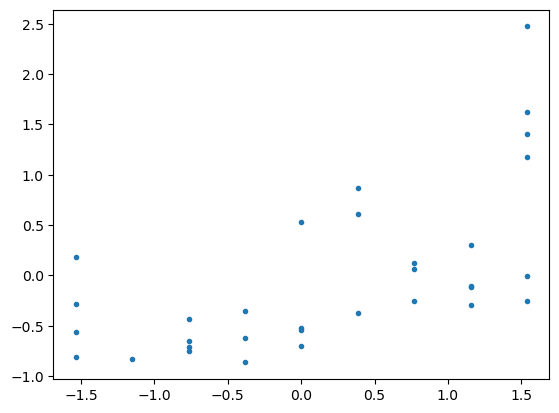

In [73]:
data_iterator = iter(train_loader)
X_iter, subgrid_tend_iter = next(data_iterator)

plt.plot(X_iter[:,1], subgrid_tend_iter, '.')

In [74]:
linear_network = LinearRegression(input_size=2)
fcnn_network = FCNN(input_size=2)

In [75]:
loss_fn = torch.nn.MSELoss()

In [76]:
# Load the input and output pair from the data loader
X_tmp = next(iter(train_loader))

# Predict the output
y_tmp_linear = linear_network(torch.unsqueeze(X_tmp[0], 1))
y_tmp_fcnn = fcnn_network(torch.unsqueeze(X_tmp[0], 1))

# Calculate the MSE loss
loss_linear = loss_fn(y_tmp_linear, torch.unsqueeze(X_tmp[1], 1))
print(f"Linear network MSE Loss: {loss_linear.item():.4f}")

loss_fcnn = loss_fn(y_tmp_fcnn, torch.unsqueeze(X_tmp[1], 1))
print(f"FCNN MSE Loss: {loss_fcnn.item():.4f}")

Linear network MSE Loss: 0.5341
FCNN MSE Loss: 0.7068


In [77]:
learning_rate = 0.003
momentum = 0.1

In [78]:
optimizer_linear = optim.Adam(linear_network.parameters(), lr=learning_rate)
print("Before backward pass: \n", list(linear_network.parameters())[0].data.numpy())

loss_linear.backward(retain_graph=True)
optimizer_linear.step()

print("\nAfter backward pass: \n", list(linear_network.parameters())[0].data.numpy())

Before backward pass: 
 [[-0.6024939  0.5183403]]

After backward pass: 
 [[-0.59949386  0.51534027]]


In [79]:
optimizer_fcnn = optim.Adam(fcnn_network.parameters(), lr=learning_rate)

In [80]:
n_epochs = 100

In [81]:
train_loss_linear, test_loss_linear = fit_model(
    linear_network, loss_fn, optimizer_linear, train_loader, test_loader, n_epochs
)

Training completed in 0 seconds.


In [82]:
train_loss_fcnn, test_loss_fcnn = fit_model(
    fcnn_network, loss_fn, optimizer_fcnn, train_loader, test_loader, n_epochs
)

Training completed in 4 seconds.


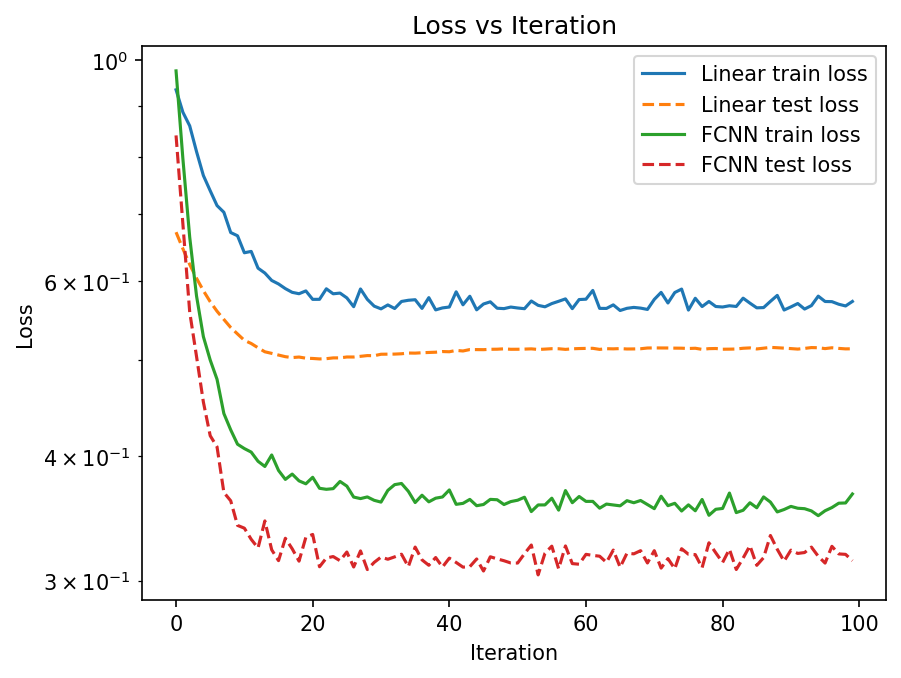

In [83]:
plt.figure(dpi=150)

plt.plot(train_loss_linear, label="Linear train loss")
plt.plot(test_loss_linear, linestyle="--", label="Linear test loss")

plt.plot(train_loss_fcnn, label="FCNN train loss")
plt.plot(test_loss_fcnn, linestyle="--", label="FCNN test loss")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show();

In [84]:
# TODO: build function to plot true and predicted m* 